 # Модифікований метод послідовних наближень
 

## Теоретичні відомості

 Ефективний метод обчислення характеристичних чисел і відповідних їм власних функцій лінійного цілком неперервного оператора, що діє у нормованому функціональному просторі, – *__модифікований метод послідовних наближень (ММПН)__* – послідовно ітерує оператором деяку початкову функцію та опрацьовує на кожному кроці всі обчислені функції. ММПН найбільш ефективний у випадках, коли спектр оператора містить групу власних чисел, близьких за абсолютною величиною до першого. Метод можна застосовувати до узагальнених спектральних задач з поліноміальною залежністю від параметра.

## Практична частина:

### Задача:

$Au=\int_0^1 G(x,t) u(t)dt$  
$u - \mu Au = 0$  
$\mu = \frac{1}{\lambda}$  
Знайти таке u $\neq$ 0, щоб рівняння вище виконувалися.

\begin{equation*}
G(x,t) = 
 \begin{cases}
   (1-x)t &\text{, t}\leq x\\
   (1-t)x &\text{, t}\geq x
 \end{cases}
\end{equation*}

$u=u(x) \textrm{  ,  } x \in [0;1]$

A-інтегральний оператор  
G-ядро  
$\mu$-характеристичне число  
$\lambda$-власне значення

__Крок 1__  
*Запрограмувати дію оператора А (перевірити чи старший коефіцієнт != 0)*  
$$v_m=Av_{m-1}$$

In [5]:
import numpy as np

def operatorA_action(p:np.poly1d)->np.poly1d:
    """ Integral operator action A """
    t = np.array([1,0]) #t
    t1 = np.array([-1,1]) #1-t

    first_int = np.polyint(np.polymul(t,p)) # інтегруємо першу частину
    first_addition = np.polymul(t1, first_int) # знаходимо перший доданок

    second_int = np.polyint(np.polymul(t1,p)) # знаходимо первісну
    second_addition = np.polymul(t, np.polysub(np.polyval(second_int,1), second_int)) # підставляємо межі інтегрування та знаходимо другий доданок

    Vm = np.polyadd(first_addition, second_addition) #сумуємо два доданки

    return Vm

def sequence_V(V0:np.poly1d, m:int)->list:
    """ The function generates the sequence Vm """
    sequence = []
    sequence.append(V0) # додаємо початкове наближення
    for i in range (m):
        sequence.append(operatorA_action(sequence[i])) # додаємо поліном в послідовність 
    return sequence

__Тести__

__Крок 2__  
*Обчислити скалярний добуток*

In [6]:
import numpy as np

def scalar_product(a_poly:np.poly1d, b_poly:np.poly1d)->float:
    """Find scalar product of two polynomials"""
    integral = np.polyint(np.polymul(a_poly, b_poly)) # множимо поліноми і знаходимо первісну
    return integral(1) - integral(0) # від інтегралу в точці 1 - інтеграл в точці 0

__Тести__

__Крок 3__  
*Знайти корені $\mu_n^{(m)}$*  
$C_0^{(m)}+C_1^{(m)}\mu+...+C_{m-1}^{(m)}\mu^{m-1}=0$

In [1]:
import numpy as np

def get_Matrix(V_m,num_of_v):
    counter_for_num_of_element = 1
    res = ""
    for counter in range(num_of_v - 1):
        counter_for_el = counter + 1
        if counter == 0:
            matrix_of_SCALAR = np.identity(num_of_v - 1)
        for i in range(counter,num_of_v - 1):
            if counter_for_el  < num_of_v:
                matrix_of_SCALAR[counter,i] = scalar_product(V_m[counter_for_num_of_element],V_m[counter_for_el])
            counter_for_el += 1
        counter_for_num_of_element+=1
        res = matrix_of_SCALAR
    res = symetrize(res)
    res = np.rot90(res,2)
    return res

def symetrize(a):
    return a + a.T - np.diag(a.diagonal())

def get_Res_vector_for_Matr(V_m,num_of_v):
    res = np.array([])
    for counter in range(1,num_of_v):
        res = np.append(res, -(scalar_product(V_m[0],V_m[counter])))
    res = np.flip(res)
    return res

def get_Vector_of_Coef(V_m,num_of_v):
    vector_of_Coef = np.linalg.solve(get_Matrix(V_m,num_of_v),get_Res_vector_for_Matr(V_m,num_of_v))
    return vector_of_Coef

__Тести__

__Крок 4_  
*Обчислити $U_n^{(m)}$*  
$U_n^{(m)}=\sum_{j=1}^m Z_j^{(m)}\mu_n^{(m)};$  
$Z_j^{(m)}=\sum_{i=0}^{j-1}c_i^{(m)}V_{j-i};$  
$n=1,2,...,m-1$


In [2]:
import numpy as np

def get_mu(c_arr:np.ndarray)-> np.ndarray:
    """Find mu"""
    mu_poly=c_arr[::-1] # від найбільшого до найменшого
    mu_values=np.roots(mu_poly) # знаходимо корені
    return mu_values

def get_z(c: np.ndarray, v: list, amount: int) -> np.ndarray:
    """Find z"""
    result = np.arange(amount, dtype=np.poly1d)  # створюємо масив поліномів
    for j in range(1, amount + 1):  # знаходимо усі z згідно формули
        val = 0
        for i in range(j):
            val += np.poly1d(c[i] * v[j - i])
        result[j - 1] = val
    return result

def get_u(z: np.ndarray, mu: np.ndarray, amount: int)->np.ndarray:
    """Find u """
    n_max = len(mu)
    result = np.arange(n_max, dtype=np.poly1d)
    for n in range(n_max):
        val = 0
        for j in range(amount):
            val += z[j] * pow(mu[n], j + 1)
        result[n] = val
    return result

__Тести__

### Результат:

[poly1d([ -5.05884323,   0.        ,  35.41190259,   0.        ,
       -82.62777271,   0.        ,  52.27471335,   0.        ])]


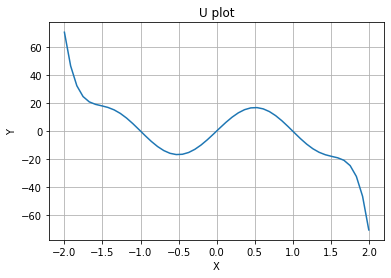

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from Functions import *
start = np.poly1d([1.,0.])
first_step = operatorA_action(start)
second_step = sequence_V(first_step,3)
third_step = get_Vector_of_Coef(second_step,3)
fourth_step = get_mu(third_step)
fifth_step = get_z(third_step,second_step,2)
last_step = get_u(fifth_step,fourth_step,2)
print(last_step)

dots = np.linspace(-2, 2, 50)
y = last_step[0](dots)
plt.plot(dots,y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("U plot")
plt.grid()
plt.show()

Перевірка:$U_n^{(m)}=\mu_n^{(m)}AU_n^{(m)}$